# Workshop Python Image Analysis
*Martijn Wehrens, September 2025*

**Estimated time:** XX mins presenting + YY mins exercises

## Chapter 3: Image Processing

### Two experiments

#### Different types of challenges

- The above approach is labor intensive, rather **automate**.
- Depends on type of data.

<br>

<img src="images/figures/biobook_fig68.png" width=75%>

*Image taken from [biobook](https://bioimagebook.github.io/chapters/2-processing/3-thresholding/thresholding.html) (fig. 68).*

#### Otsu's method

Otsu’s method, introduced in 1979, has become an extremely popular approach to determining a threshold. It’s commonly described, somewhat intimidatingly, as ‘minimizing the intra-class intensity variance’. In essence, calculating a threshold using Otsu’s method involves adding the variance of the background pixels to the variance of the foreground pixels, for all possible thresholds. The threshold that is selected is the one for which the sum of the variances is smallest.

*Source: [biobook](https://bioimagebook.github.io/chapters/2-processing/3-thresholding/thresholding.html).*

#### More thresholding-finding algorithms

Other methods include:
- Threshold determined by estimate of background
- Triangle method
- Yen method
- (..)

**A list can be found at** [scikit image's documentation](https://scikit-image.org/docs/0.23.x/auto_examples/segmentation/plot_thresholding.html).

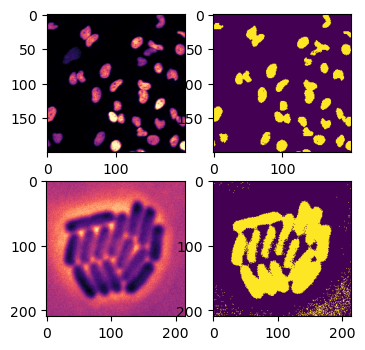

In [ ]:
# Let's also load an image of some bacteria
path_img_ecoli = 'images/biological/microcolony_ecoli.tif'
img_ecoli = tiff.imread(path_img_ecoli)
# invert image
img_ecoli_inv = np.max(img_ecoli)-img_ecoli

# Let's see how Otsu performs with nuclei and bacteria
mask_nuclei_otsu = img_nuclei > sk.filters.threshold_otsu(img_nuclei)
mask_ecoli_otsu = img_ecoli_inv > sk.filters.threshold_otsu(img_ecoli_inv)

# Display
fig, axs = plt.subplots(2,2, figsize=FIGSIZE22)
_ = axs[0,0].imshow(img_nuclei, cmap='magma')
_ = axs[0,1].imshow(mask_nuclei_otsu)
_ = axs[1,0].imshow(img_ecoli, cmap='magma')
_ = axs[1,1].imshow(mask_ecoli_otsu)
plt.show()

# Some nuclei fail to detect
# Bacteria aren't properly segmented

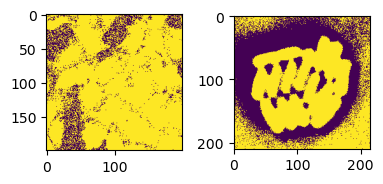

In [81]:
# Identify the background signal, using the mode

# Calculate the mode (applicable distributions with large background areas)
mode_nuclei = (1+stats.mode(img_nuclei, axis=None).mode)
mode_ecoli  = (1+stats.mode(img_ecoli_inv, axis=None).mode)

# Show the thresholded result
fig, ax = plt.subplots(1, 2, figsize=FIGSIZE22)
_ = ax[0].imshow(1*img_nuclei>mode_nuclei)
_ = ax[1].imshow(1*img_ecoli_inv>mode_ecoli)
plt.tight_layout()

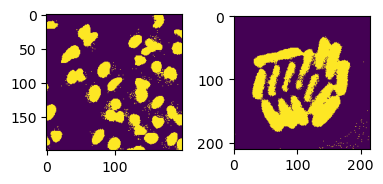

In [84]:
# Now use the triangle method

mask_nuclei_triangle = img_nuclei > sk.filters.threshold_triangle(img_nuclei)
mask_ecoli_triangle = img_ecoli_inv > sk.filters.threshold_triangle(img_ecoli_inv)

# Display
fig, axs = plt.subplots(1,2, figsize=FIGSIZE21)
_ = axs[0].imshow(mask_nuclei_triangle)
_ = axs[1].imshow(mask_ecoli_triangle)
plt.tight_layout()

# Works better for nuclei!


<font color=red size=5>

- Continue below
- Make end goal bacterial and nuclear segmentation
- Make it more structured, to introduce concepts one by one


</font>



<font color=red size=5>


# Old code

</font>

## Using "neighborhood" information

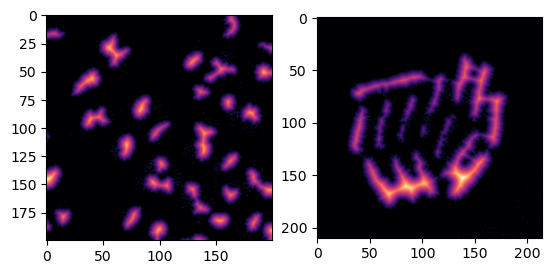

In [95]:
# Perform a distance perform on the bacterial image
distance_nuclei = ndimage.distance_transform_edt(mask_nuclei_triangle)
distance_ecoli = ndimage.distance_transform_edt(mask_ecoli_triangle)


# Show it
fig, axs = plt.subplots(1,2)
_=axs[0].imshow(distance_nuclei, cmap='magma')
_=axs[1].imshow(distance_ecoli, cmap='magma')

<font color=red size=5>
Introduce labels somewhere here, because for the nuclei this already works well!
</font>

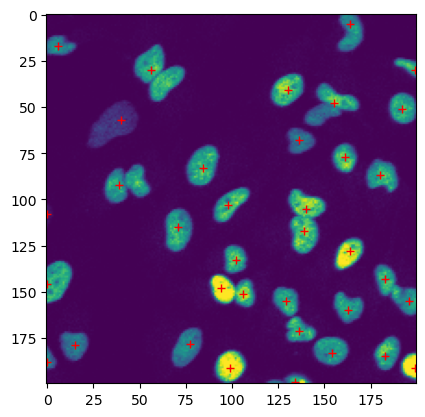

In [128]:
# Get local maxima for the nuclei
local_max_nuclei = sk.feature.peak_local_max(distance_nuclei, 
                                             min_distance = 10,
                                             threshold_abs = 3,
                                             footprint=sk.morphology.disk(10),
                                             exclude_border=False)

# Plot the nuclei picture, and plot the local maxima on top as crosses
fig, ax = plt.subplots()
_ = ax.imshow(img_nuclei, cmap='viridis')
x = local_max_nuclei[:, 1]
y = local_max_nuclei[:, 0]
_ = ax.plot(x, y, 'r+')


<font color=red size=4>^Note that this does work for some nuclei.</font>

In [115]:
local_max_nuclei

array([[146,   1],
       [ 30,  56],
       [ 57,  40],
       ...,
       [198, 119],
       [198, 190],
       [198, 192]], shape=(534, 2))

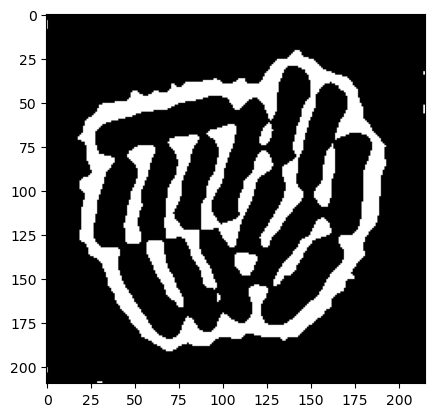

In [108]:
# Show the result of sobel edge detection on the bacteria
edges_sobel = sk.filters.sobel(img_ecoli_inv)
plt.imshow(edges_sobel, cmap='magma')
# Show the results of LoG on the bacteria
edges_log = sk.filters.laplace(sk.filters.gaussian(img_ecoli, sigma=3))
plt.imshow(edges_log, cmap='magma')
# Threshold edges_log by triangle method
mask_ecoli_log = edges_log > sk.filters.threshold_triangle(edges_log)
plt.imshow(mask_ecoli_log, cmap='gray')



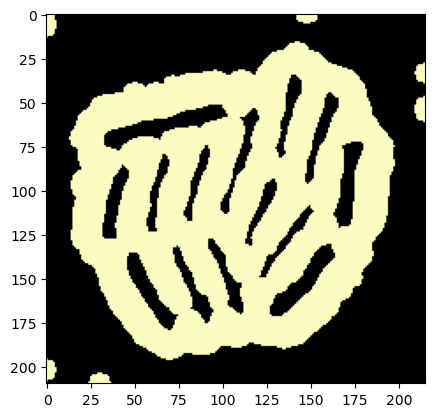

In [111]:
# Now dilate the mask
# define a circle of radius 3
element_disk = sk.morphology.disk(5)
mask_ecoli_dilated = ndimage.binary_dilation(mask_ecoli_log, structure=element_disk)
# Show the result
plt.imshow(mask_ecoli_dilated, cmap='magma')

np.False_